In [1]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import os
import sys
import seaborn as sns
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/Pedophysics_code')
sys.path.insert(0, 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code')

from pedophysics import predict, Soil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr
from IPython.display import clear_output


from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from PyPDF2 import PdfMerger

# Electromagnetic induction data inversion package
from plots import *
from PM import *
import sys
%matplotlib inline

pd.set_option('display.max_columns', None)
from utils.spatial_utils import get_coincident


# Configure input

In [2]:
# User input
s_site = 'M'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
datafolder = 'Data' # data folder
em_intype = 'reca'   # 'reca', 'LIN' 
cal = 'calibrated' # 'non_calibrated', 'drift_calibrated'
instrument_code = '421S' # 421S, '21HS'

## Load data

In [3]:
if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if instrument_code == '21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)

cal_folder = os.path.join(datafolder, cal)
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_{cal}_{em_intype}.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')
inv_s = os.path.join(datafolder, f'{profile_prefix}_inverted_samples_{instrument_code}d.csv')

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
em_survey = pd.read_csv(em_survey, sep=',', header=0)
inverted = pd.read_csv(inv_s, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)
em_samples = get_coincident(em_survey, samples)


print('em_samples', em_samples.head())

em_samples                  x            y         z         t      HCP1.0      PRP1.1  \
5793   41564.55393  204206.5969  0.550000  46700.42  150.158994   72.924179   
11585  41548.70964  204311.5916  0.849275  48080.26  134.086763  115.131030   
7013   41589.74878  204167.8323  0.550000  46944.42  188.638104   96.941128   
25276  41668.93880  204238.3062  0.450000  53527.92  182.368752   90.934958   
8604   41521.70418  204334.5502  0.850000  47262.62  205.244726  169.078652   

           HCP2.0      PRP2.1      HCP4.0      PRP4.1  HCP1.0_inph  \
5793   226.953252  115.025705  373.365468  196.757269     2.067101   
11585  161.880664  111.225743  252.692239  134.483623     1.837964   
7013   279.010673  159.068562  412.452460  254.330522     2.168737   
25276  274.737296  157.622797  400.916603  254.547953     2.145960   
8604   256.759837  187.403245  345.966089  242.110278     1.986835   

       PRP1.1_inph  HCP2.0_inph  PRP2.1_inph  HCP4.0_inph  PRP4.1_inph  code  \
5793      0.1

# Data Analysis
### Data wrangling

In [4]:
ds_c = em_samples.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

ds_c['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds_c.bulk_ec_hp.values))

ds_c['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds_c.bulk_ec_hp, ds_c.temp)
ds_c['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values,
                                                    bulk_ec_dc = ds_c.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

In [5]:
inv_columns = inverted.columns[3:-1]
ds_c[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(inverted.x)):
        ds_c.loc[ds_c.code == i+1, c] = inverted.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

# Apply the function to each row
ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds_c.bulk_ec_inv.values/1000))*1000


ds_c['ideal_bulk_ec'] = predict.BulkEC(
                                        Soil(temperature = ds_c.temp.values+273.15,
                                             water = ds_c.vwc.values,
                                             clay = ds_c.clay.values,
                                             bulk_density = ds_c.bd.values,
                                             water_ec = ds_c.water_ec_hp.values,
                                             frequency_ec = 9e3
                                            )

)

if instrument_code == '21HS':
    feature_set = [
        'HCP0.5',
        'HCP1.0',
        'HCP2.0',
        'PRP0.6',
        'PRP1.1',
        'PRP2.1',
        'bulk_ec_inv',
    #    'bulk_ec_dc_tc_inv',
    #    'bulk_ec_hp',
    #    'bulk_ec_dc_tc_hp'
    ]
elif instrument_code == '421S':
    feature_set = [
        'HCP1.0',
        'HCP2.0',
        'HCP4.0',
        'PRP1.1',
        'PRP2.1',
        'PRP4.1',
        'bulk_ec_inv',
    #    'bulk_ec_dc_tc_inv',
    #    'bulk_ec_hp',
    #    'bulk_ec_dc_tc_hp'
    ]

folder_path = 'output_tables/'
file_name = 'ds_c_'+profile_prefix+'.csv'
ds_c.to_csv(folder_path + file_name, index=False)

print(ds_c)

conversion <function conversion at 0x000001CC691628E0>
soil.df.frequency_ec 0     9000.0
1     9000.0
2     9000.0
3     9000.0
4     9000.0
5     9000.0
6     9000.0
7     9000.0
8     9000.0
9     9000.0
10    9000.0
11    9000.0
12    9000.0
13    9000.0
14    9000.0
15    9000.0
16    9000.0
17    9000.0
18    9000.0
19    9000.0
20    9000.0
21    9000.0
22    9000.0
23    9000.0
24    9000.0
25    9000.0
26    9000.0
27    9000.0
28    9000.0
29    9000.0
Name: frequency_ec, dtype: float64
                 x            y         z         t      HCP1.0      PRP1.1  \
5793   41564.55393  204206.5969  0.550000  46700.42  150.158994   72.924179   
11585  41548.70964  204311.5916  0.849275  48080.26  134.086763  115.131030   
7013   41589.74878  204167.8323  0.550000  46944.42  188.638104   96.941128   
25276  41668.93880  204238.3062  0.450000  53527.92  182.368752   90.934958   
8604   41521.70418  204334.5502  0.850000  47262.62  205.244726  169.078652   
19374  41617.19729  20425

### Correlations

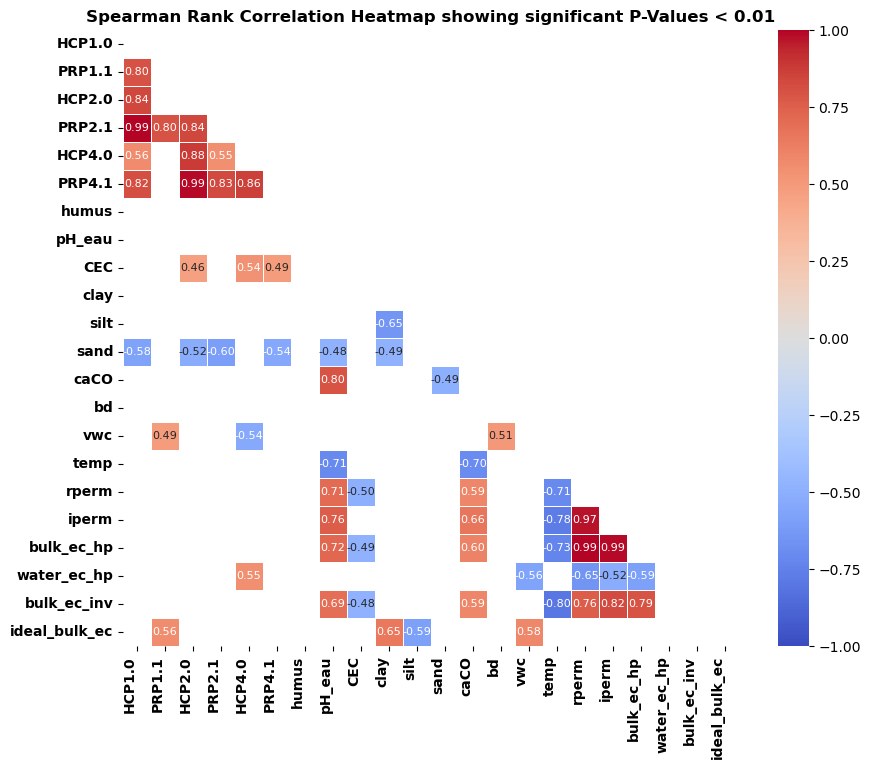

In [6]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in ds_c.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(ds_c[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.01
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot

folder_path = 'output_images/'
filename = f"Corr_{s_site}_{cal}_{em_intype}.pdf"
plt.savefig(folder_path + filename)
plt.show()



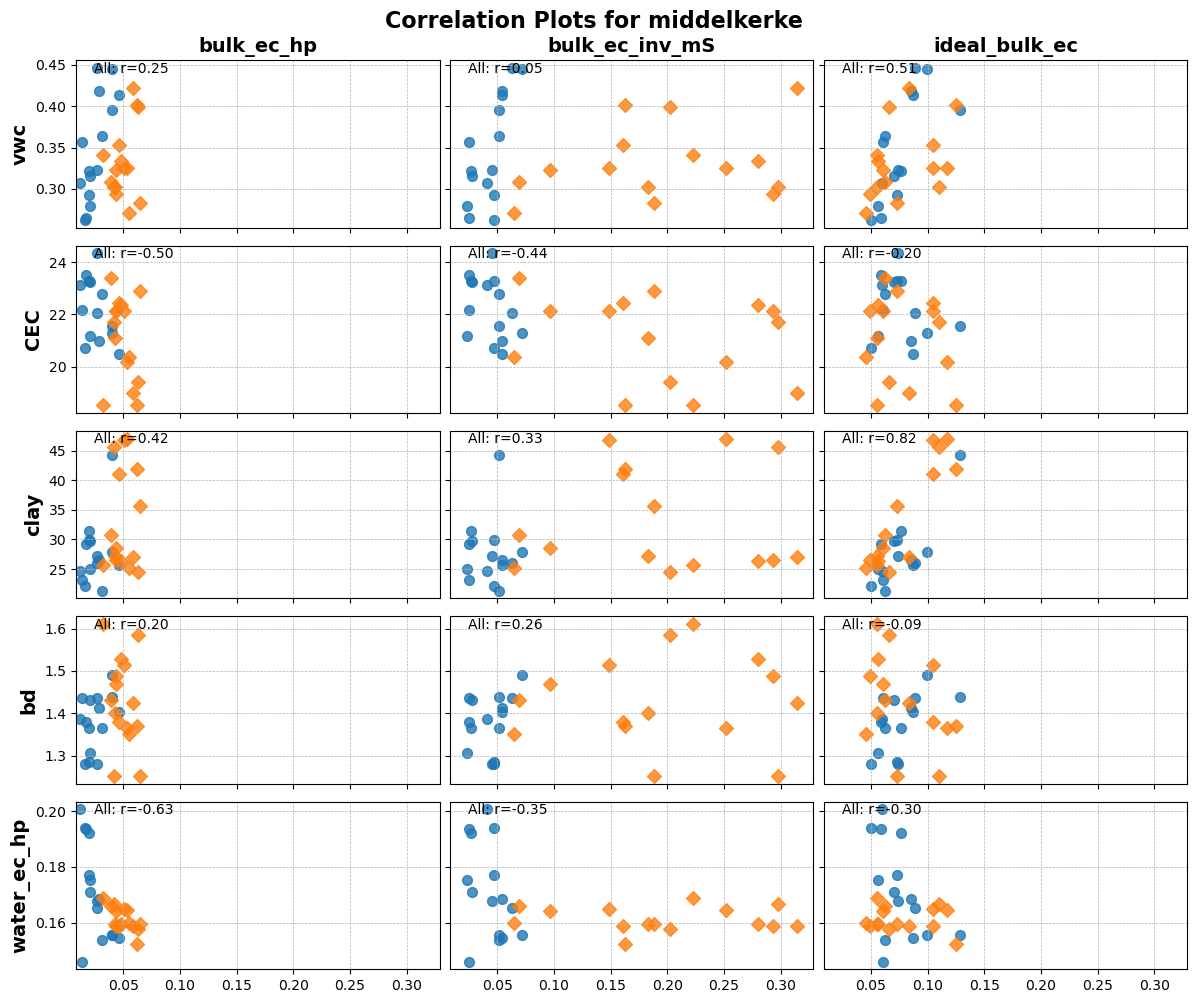

In [7]:
fig, axes = plt.subplots(5, 3, figsize=(12, 10))
ss = 50  # Reduced size for scatter points

ds_c['bulk_ec_inv_mS'] = ds_c.bulk_ec_inv/1000
preds = ['bulk_ec_hp', 'bulk_ec_inv_mS', 'ideal_bulk_ec']

def corr_plot(df, preds, targets):
    global_max_x = float('-inf')
    global_min_x = float('inf')

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):
            ax = axes[target_index, pred_index]
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')

            if target_index == 0:
                ax.set_title(pred, fontweight='bold', fontsize=14)
            if target_index != len(targets) - 1:
                ax.set_xticklabels([])

            if pred_index == 0:
                ax.set_ylabel(target, fontweight='bold', fontsize=14)
            if pred_index != 0:
                ax.set_yticklabels([])

            # Update global max and min x values
            x_min, x_max = ax.get_xlim()
            global_max_x = max(global_max_x, x_max)
            global_min_x = min(global_min_x, x_min)

    # Set the same x-axis limits for all subplots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlim(global_min_x, global_max_x)

corr_plot(ds_c, preds, ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp'])

plt.subplots_adjust(top=0.7)  # You can adjust this value as needed
plt.suptitle(f"Correlation Plots for {profile_prefix}", fontweight='bold', fontsize=16, y=0.99)  # Adjust y as needed
plt.tight_layout(pad=0.5, w_pad=0.4, h_pad=0.8)

folder_path = 'output_images/'
filename = f"Plot_{s_site}.pdf"
plt.savefig(folder_path + filename)
plt.show()

# Deterministic modelling

## Implementation

In [8]:
clay_50cm = np.mean(ds_c.clay[ds_c['depth']==50])
clay_10cm = np.mean(ds_c.clay[ds_c['depth']==10])
bd_50cm = np.mean(ds_c.bd[ds_c['depth']==50])
bd_10cm = np.mean(ds_c.bd[ds_c['depth']==10])
water_ec_hp_50cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==50])
water_ec_hp_10cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==10])
clay_mean = np.mean(ds_c.clay)
bd_mean = np.mean(ds_c.bd)
water_ec_hp_mean = np.mean(ds_c.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_c.water_ec_hp_t)
temp_50cm = np.mean(ds_c.temp[ds_c['depth']==50])
temp_10cm = np.mean(ds_c.temp[ds_c['depth']==10])
temp_mean = np.mean(ds_c.temp)
vwc_50cm = np.mean(ds_c.vwc[ds_c['depth']==50])
vwc_10cm = np.mean(ds_c.vwc[ds_c['depth']==10])
vwc_mean = np.mean(ds_c.vwc)

In [9]:
def deterministic(feature, target, df, iters=100, round_n=3):
  df.reset_index(drop=True, inplace=True)

  ### Extract indices for 10 cm and 50 cm layers
  idx_layer_10 = df[df['depth'] == 10].index
  idx_layer_50 = df[df['depth'] == 50].index
  ### Select data at 10 cm depth
  X_layer_10 = df.loc[idx_layer_10, feature].values.reshape(-1, 1)
  Y_layer_10 = df.loc[idx_layer_10, target].values
  ### Select data at 50 cm depth
  X_layer_50 = df.loc[idx_layer_50, feature].values.reshape(-1, 1)
  Y_layer_50 = df.loc[idx_layer_50, target].values

  f_ec = 9000
  t_conv = 273.15
  t_50cm_conv = temp_50cm+t_conv
  t_10cm_conv = temp_10cm+t_conv
  t_mean_conv = temp_mean+t_conv

  # Preallocate lists
  DR2_LS, DRMSE_LS = [None] * iters, [None] * iters
  DR2_LT, DRMSE_LT = [None] * iters, [None] * iters
  DR2_10, DRMSE_10 = [None] * iters, [None] * iters
  DR2_50, DRMSE_50 = [None] * iters, [None] * iters
  DR2_ID, DRMSE_ID, ypred_ID_ = [None] * iters, [None] * iters, [None] * iters
  y_ = [None] * iters
  
  for i in range(iters):
    ### Split data of 10cm layer and keep track of test indices
    X_train10, X_test10, y_train10, y_test10, idx_train10, idx_test10 = train_test_split(X_layer_10, Y_layer_10, idx_layer_10, test_size=0.3, random_state=i)
    ### Split data of 50cm layer and keep track of test indices
    X_train50, X_test50, y_train50, y_test50, idx_train50, idx_test50 = train_test_split(X_layer_50, Y_layer_50, idx_layer_50, test_size=0.3, random_state=i)

    ### Combine test indices from both layers
    idx_test = np.concatenate((idx_test10, idx_test50))
    y_test = np.concatenate((y_test10, y_test50)).flatten()
    X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
    y_[i] = y_test

    ### Predict using layer together 
    LT = Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = clay_mean,
                bulk_density = bd_mean,
                water_ec = water_ec_hp_mean,
                temperature = t_mean_conv
                  )
    Dypred_LT = predict.Water(LT)
    DR2_LT[i] = round(r2_score(y_test, Dypred_LT), round_n)
    DRMSE_LT[i] = round(RMSE(y_test, Dypred_LT), round_n)

    ### Predict using 10 cm layer
    layer_10 = Soil( 
                bulk_ec = X_test10.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_10cm,
                bulk_density = bd_10cm,
                water_ec = water_ec_hp_10cm,
                temperature = t_10cm_conv
                  )
    Dypred_10 = predict.Water(layer_10)
    DR2_10[i] = round(r2_score(y_test10, Dypred_10), round_n)
    DRMSE_10[i] = round(RMSE(y_test10, Dypred_10), round_n)

    ### Predict using 50 cm layer
    layer_50 = Soil( 
                bulk_ec = X_test50.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_50cm,
                bulk_density = bd_50cm,
                water_ec = water_ec_hp_50cm,
                temperature = t_50cm_conv
                  )
    Dypred_50 = predict.Water(layer_50)
    DR2_50[i] = round(r2_score(y_test50, Dypred_50), round_n)
    DRMSE_50[i] = round(RMSE(y_test50, Dypred_50), round_n)

    ### Stochastic modelling for layers separate. 
    ### This is a combination of both layer's prediction
    Dypred_LS = np.concatenate((Dypred_10, Dypred_50))
    DR2_LS[i] = round(r2_score(y_test, Dypred_LS), round_n)
    DRMSE_LS[i] = round(RMSE(y_test, Dypred_LS), round_n)

    ### Predict using ideal samples
    filtered_df = df.loc[idx_test]
    ID =  Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = filtered_df['clay'].values,
                bulk_density = filtered_df['bd'].values,
                water_ec = filtered_df['water_ec_hp'].values,
                temperature = filtered_df['temp'].values+t_conv
                  )
    Dypred_ID = predict.Water(ID)
    ypred_ID_[i] = Dypred_ID
    DR2_ID[i] = round(r2_score(y_test, Dypred_ID), round_n)
    DRMSE_ID[i] = round(RMSE(y_test, Dypred_ID), round_n)

  return DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50

Dresults = {}
target = 'vwc'
%timeit

for feature in feature_set:
  DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50 = deterministic(feature, target, ds_c)

  Dresults[feature] = {
        'LT': {'R2': DR2_LT, 'RMSE': DRMSE_LT},
        'LS': {'R2': DR2_LS, 'RMSE': DRMSE_LS},
        'ID': {'R2': DR2_ID, 'RMSE': DRMSE_ID},
  'layer 10': {'R2': DR2_10, 'RMSE': DRMSE_10},
  'layer 50': {'R2': DR2_50, 'RMSE': DRMSE_50}
  }
  %timeit
%timeit

## Process results

In [10]:
# Convert results to DataFrame for easier processing
Dresults_df = pd.DataFrame(Dresults).T.stack().reset_index()
Dresults_df.columns = ['Feature', 'Model', 'Scores']
Dresults_df = Dresults_df.join(pd.DataFrame(Dresults_df.pop('Scores').values.tolist()))

# Calculate median of each list in RMSE and R2 columns
Dresults_df['Median RMSE'] = Dresults_df['RMSE'].apply(lambda x: np.median(x))
Dresults_df['Median R2'] = Dresults_df['R2'].apply(lambda x: np.median(x))

# Create a DataFrame for median scores
median_scores = Dresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]

# Find best features based on criteria
error_criteria = 'RMSE'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

# Prepare final DataFrame
DR2_results = pd.DataFrame({
    'Target': target,
    'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0],
    'R2 LT':           best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0],
    'Best Feature ID': best_features.loc[best_features['Model'] == 'ID', 'Feature'].values[0],
    'R2 ID':           best_features.loc[best_features['Model'] == 'ID', 'Median R2'].values[0],
    'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0],
    'R2 LS':           best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0],
    'Best Feature 10': best_features.loc[best_features['Model'] == 'layer 10', 'Feature'].values[0],
    'R2 10':           best_features.loc[best_features['Model'] == 'layer 10', 'Median R2'].values[0],
    'Best Feature 50': best_features.loc[best_features['Model'] == 'layer 50', 'Feature'].values[0],
    'R2 50':           best_features.loc[best_features['Model'] == 'layer 50', 'Median R2'].values[0]
}, index=[0])

folder_path = 'output_tables/'
file_name = 'DR2_results' + '_' + s_site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.xlsx'
DR2_results.to_excel(folder_path + file_name, index=False)
DR2_results

,Target,Best Feature LT,R2 LT,Best Feature ID,R2 ID,Best Feature LS,R2 LS,Best Feature 10,R2 10,Best Feature 50,R2 50
0,vwc,PRP1.1,-8.3545,PRP1.1,-6.7255,PRP1.1,-8.3785,bulk_ec_inv,-4.067,PRP1.1,-15.533


## Plot results

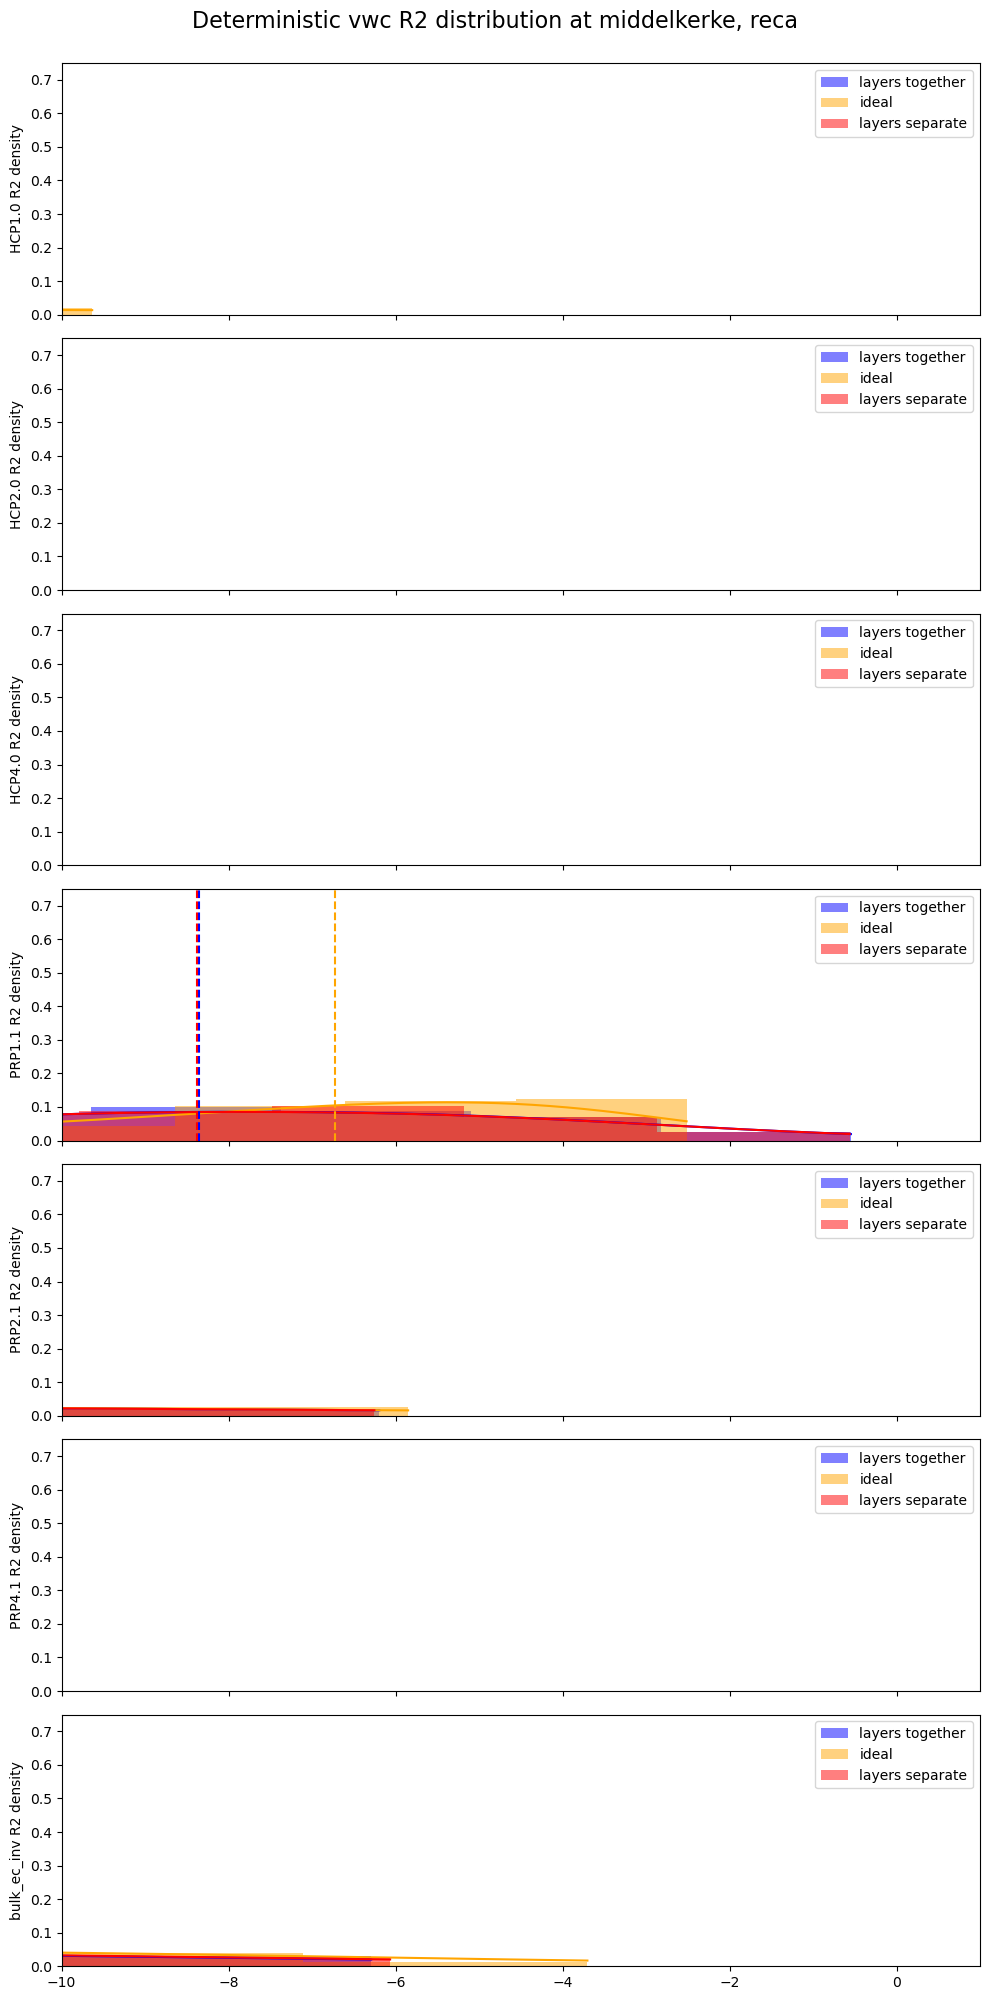

In [11]:
plot_det(Dresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'orange')

# Stochastic modelling

## Implementation

In [12]:
def stochastic(features, target, df, criteria='R2', n=4, iters=100, round_n=3):
    ### Defining lists to store results and error indicators
    SR2_train_10_, SR2_test_10_, Sypred_test_10_ = [], [], []
    SR2_train_50_, SR2_test_50_, Sypred_test_50_ = [], [], []
    SR2_train_LT_, SR2_test_LT_ = [], []
    SR2_train_LS_, SR2_test_LS_ = [], []
    y_test_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, features].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, features].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        SR2_train_10, SR2_test_10, Sypred_test_10 = [], [], []
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        SR2_train_50, SR2_test_50, Sypred_test_50 = [], [], []
        ### Combine test indices from both layers
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_train = np.concatenate((X_train10, X_train50))
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_test_.append(y_test)

        SR2_train_LS, SR2_test_LS = [], []
        SR2_train_LT, SR2_test_LT = [], []

        for k in range(n):

            #### Stochastic modelling for layers together
            polyLT = PolynomialFeatures(degree=k)
            polyLT.fit(X_train)
            Xt_trainLT = polyLT.transform(X_train)
            Xt_testLT = polyLT.transform(X_test.reshape(-1, 1))
            LinRegLT = LinearRegression()
            LinRegLT.fit(Xt_trainLT, y_train)
            Sypred_trainLT = LinRegLT.predict(Xt_trainLT)
            Sypred_testLT = LinRegLT.predict(Xt_testLT)
                # Save results and error indicators over polinomial degrees
            SR2_train_LT.append(round(r2_score(y_train, Sypred_trainLT), round_n))
            SR2_test_LT.append(round(r2_score(y_test, Sypred_testLT), round_n))

            #### Stochastic modelling 10 cm layer
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)
            LinReg10.fit(Xt_train10, y_train10)
            Sypred_train10 = LinReg10.predict(Xt_train10)
            Sypred_test10 = LinReg10.predict(Xt_test10)
                # Save results and error indicators over polinomial degrees
            Sypred_test_10.append(Sypred_test10)
            SR2_train_10.append(round(r2_score(y_train10, Sypred_train10), round_n))
            SR2_test_10.append(round(r2_score(y_test10, Sypred_test10), round_n))

            #### Stochastic modelling 50 cm layer
            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)
            LinReg50.fit(Xt_train50, y_train50)
            Sypred_train50 = LinReg50.predict(Xt_train50)
            Sypred_test50 = LinReg50.predict(Xt_test50)
                # Save results and error indicators over polinomial degrees
            Sypred_test_50.append(Sypred_test50)
            SR2_train_50.append(round(r2_score(y_train50, Sypred_train50), round_n))
            SR2_test_50.append(round(r2_score(y_test50, Sypred_test50), round_n))

            ### Stochastic modelling for layers separate. 
            ### This is a combination of both layer's prediction
            Sypred_train_LS = np.concatenate((Sypred_train10, Sypred_train50))
            Sypred_test_LS = np.concatenate((Sypred_test10, Sypred_test50))

            SR2_train_LS.append(round(r2_score(y_train, Sypred_train_LS), round_n))
            SR2_test_LS.append(round(r2_score(y_test, Sypred_test_LS), round_n))

        # Save results over all splits
        SR2_train_10_.append(SR2_train_10)
        SR2_test_10_.append(SR2_test_10)
        Sypred_test_10_.append(Sypred_test_10)

        SR2_train_50_.append(SR2_train_50)
        SR2_test_50_.append(SR2_test_50)
        Sypred_test_50_.append(Sypred_test_50)

        SR2_train_LS_.append(SR2_train_LS)
        SR2_test_LS_.append(SR2_test_LS)

        SR2_train_LT_.append(SR2_train_LT)
        SR2_test_LT_.append(SR2_test_LT)

        SR2_test_LS0 = [inner_list[0] for inner_list in SR2_test_LS_]
        SR2_test_LS1 = [inner_list[1] for inner_list in SR2_test_LS_]
        SR2_test_LS2 = [inner_list[2] for inner_list in SR2_test_LS_]
        SR2_test_LS3 = [inner_list[3] for inner_list in SR2_test_LS_]

        SR2_test_LT0 = [inner_list[0] for inner_list in SR2_test_LT_]
        SR2_test_LT1 = [inner_list[1] for inner_list in SR2_test_LT_]
        SR2_test_LT2 = [inner_list[2] for inner_list in SR2_test_LT_]
        SR2_test_LT3 = [inner_list[3] for inner_list in SR2_test_LT_]
        #####

        SR2_test_10_0 = [inner_list[0] for inner_list in SR2_test_10_]
        SR2_test_10_1 = [inner_list[1] for inner_list in SR2_test_10_]
        SR2_test_10_2 = [inner_list[2] for inner_list in SR2_test_10_]
        SR2_test_10_3 = [inner_list[3] for inner_list in SR2_test_10_]

        SR2_test_50_0 = [inner_list[0] for inner_list in SR2_test_50_]
        SR2_test_50_1 = [inner_list[1] for inner_list in SR2_test_50_]
        SR2_test_50_2 = [inner_list[2] for inner_list in SR2_test_50_]
        SR2_test_50_3 = [inner_list[3] for inner_list in SR2_test_50_]

    #########################
    if criteria == 'R2':

        SR2_10 = [SR2_test_10_0, SR2_test_10_1, SR2_test_10_2, SR2_test_10_3]
        SR2_meadian_10 = [np.median(sublist) for sublist in SR2_10]
        best_n_10 = SR2_meadian_10.index(np.max(SR2_meadian_10))
        SR2_test_10b = SR2_10[best_n_10]

        SR2_50 = [SR2_test_50_0, SR2_test_50_1, SR2_test_50_2, SR2_test_50_3]
        SR2_meadian_50 = [np.median(sublist) for sublist in SR2_50]
        best_n_50 = SR2_meadian_50.index(np.max(SR2_meadian_50))
        SR2_test_50b = SR2_50[best_n_50]

        SR2_LT = [SR2_test_LT0, SR2_test_LT1, SR2_test_LT2, SR2_test_LT3]
        SR2_meadian_LT = [np.median(sublist) for sublist in SR2_LT]
        best_n_LT = SR2_meadian_LT.index(np.max(SR2_meadian_LT))
        SR2_test_LTb = SR2_LT[best_n_LT]

        SR2_LS = [SR2_test_LS0, SR2_test_LS1, SR2_test_LS2, SR2_test_LS3]
        SR2_meadian_LS = [np.median(sublist) for sublist in SR2_LS]
        best_n_LS = SR2_meadian_LS.index(np.max(SR2_meadian_LS))
        SR2_test_LSb = SR2_LS[best_n_LS]

        ### Based on the best dgrees per layer, make up the LS2 model, the one that uses models for layer which are not necesarely equal. 
        SR2_test_LS2b = []
        for j in range(iters):
            Sypred_test_10b = [inner_list[best_n_10] for inner_list in Sypred_test_10_][j]
            Sypred_test_50b = [inner_list[best_n_50] for inner_list in Sypred_test_50_][j]

            Sypred_LS2b = np.concatenate((Sypred_test_10b, Sypred_test_50b))
            SR2_test_LS2b.append(round(r2_score(y_test_[j], Sypred_LS2b), round_n))

        best_n_LS2 = [best_n_10, best_n_50]
    best_ns = [best_n_LT, best_n_LS, best_n_LS2]
    return SR2_test_LTb, SR2_test_LSb, SR2_test_LS2b, SR2_test_10b, SR2_test_50b, best_ns

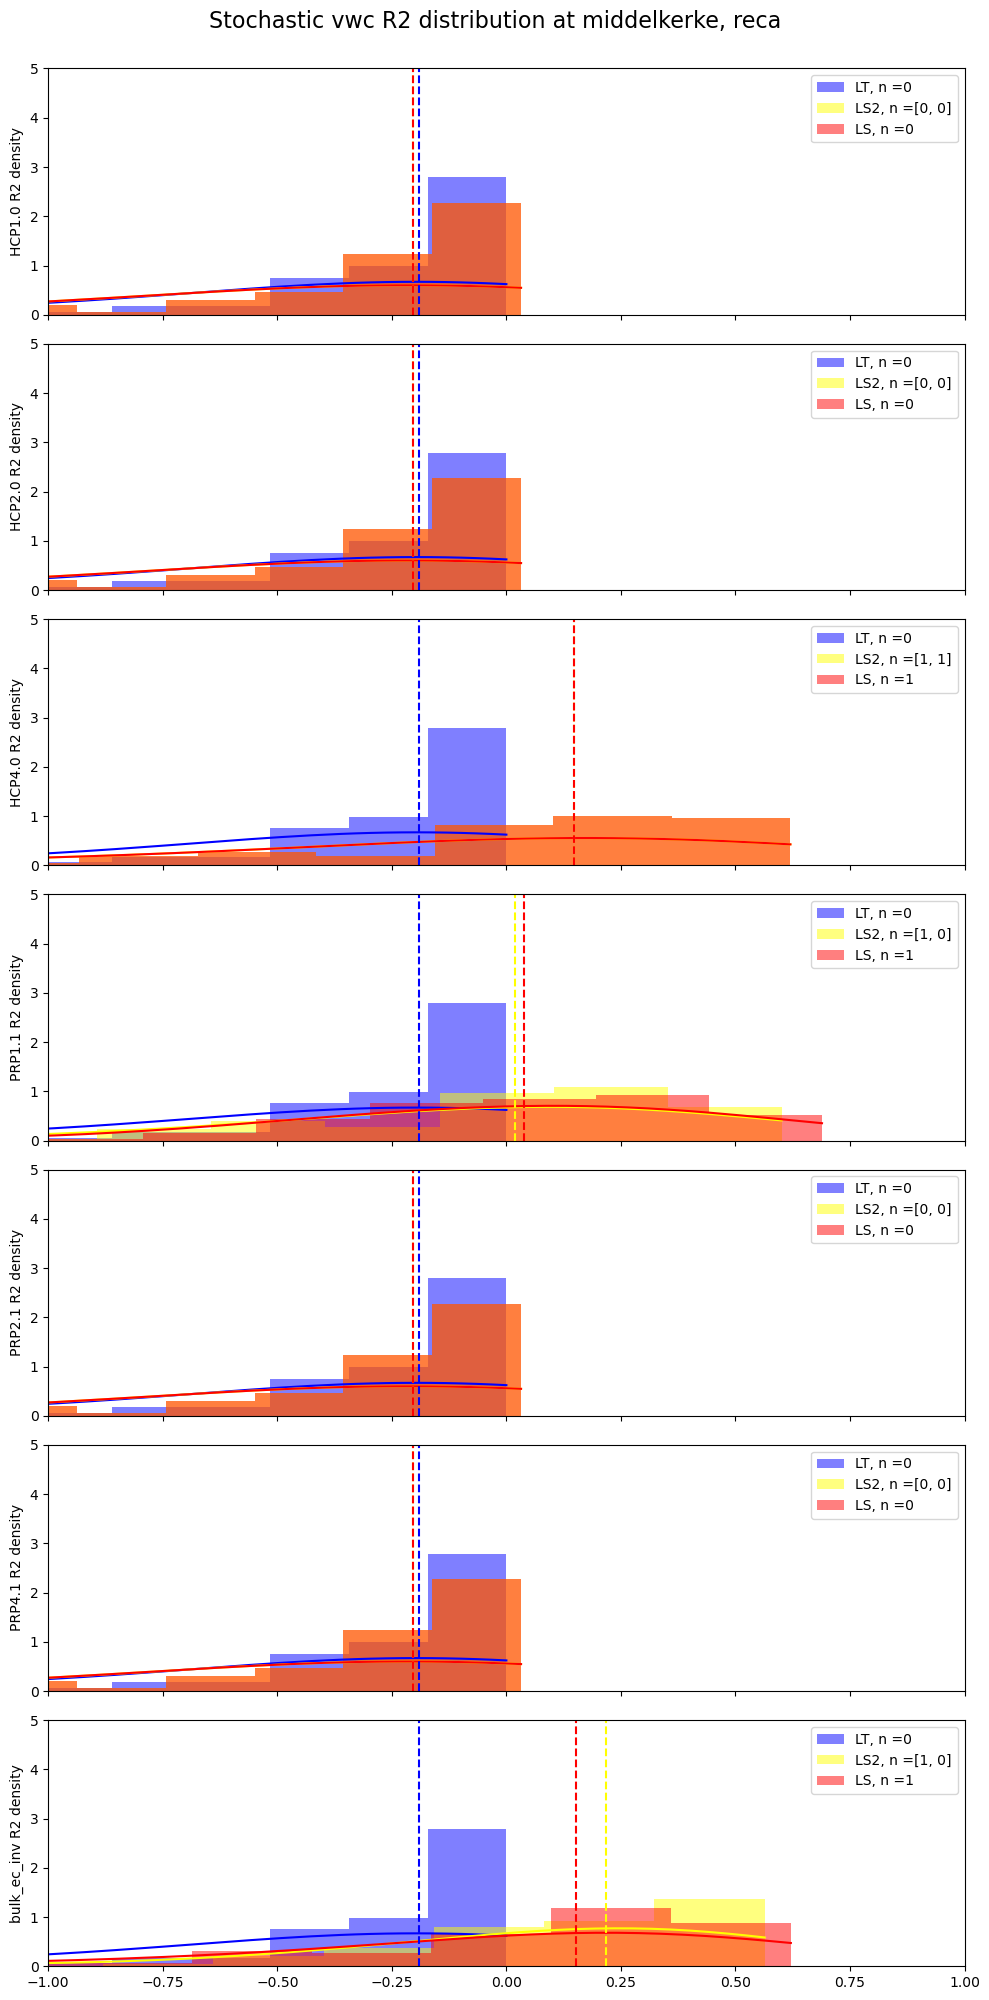

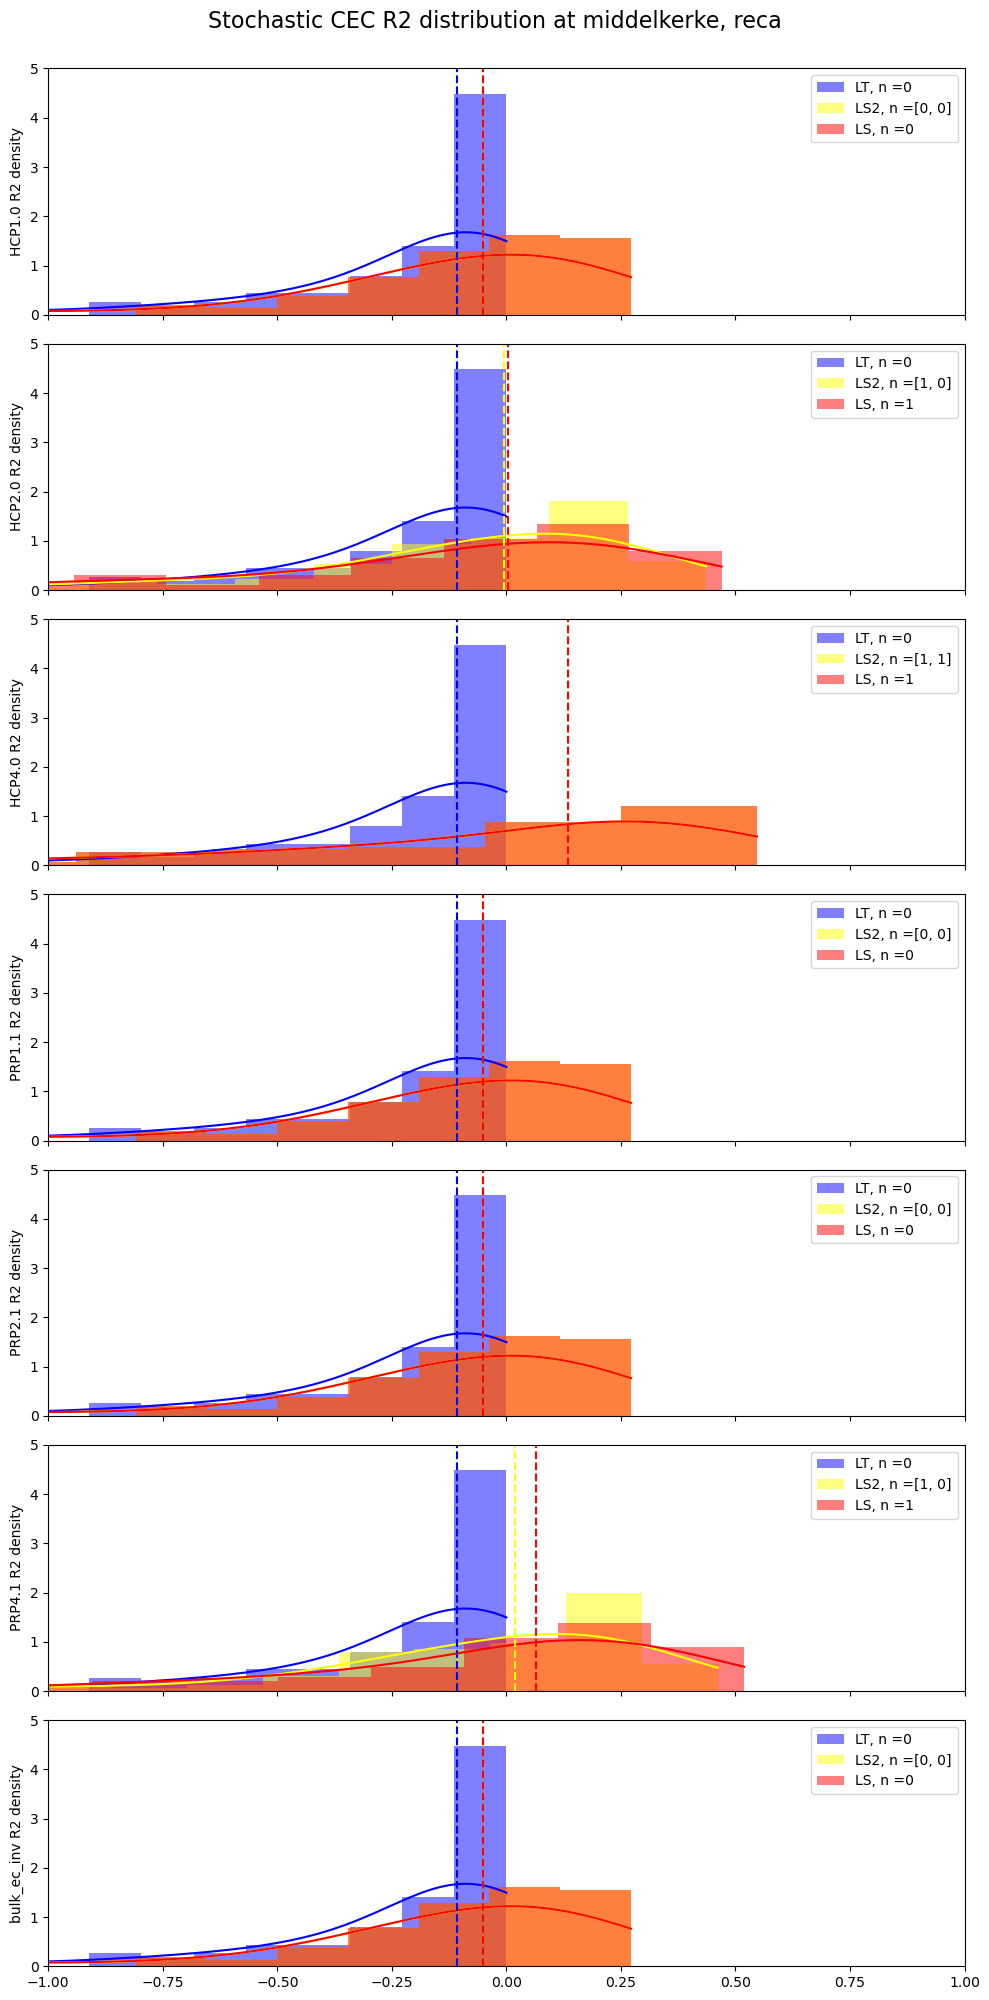

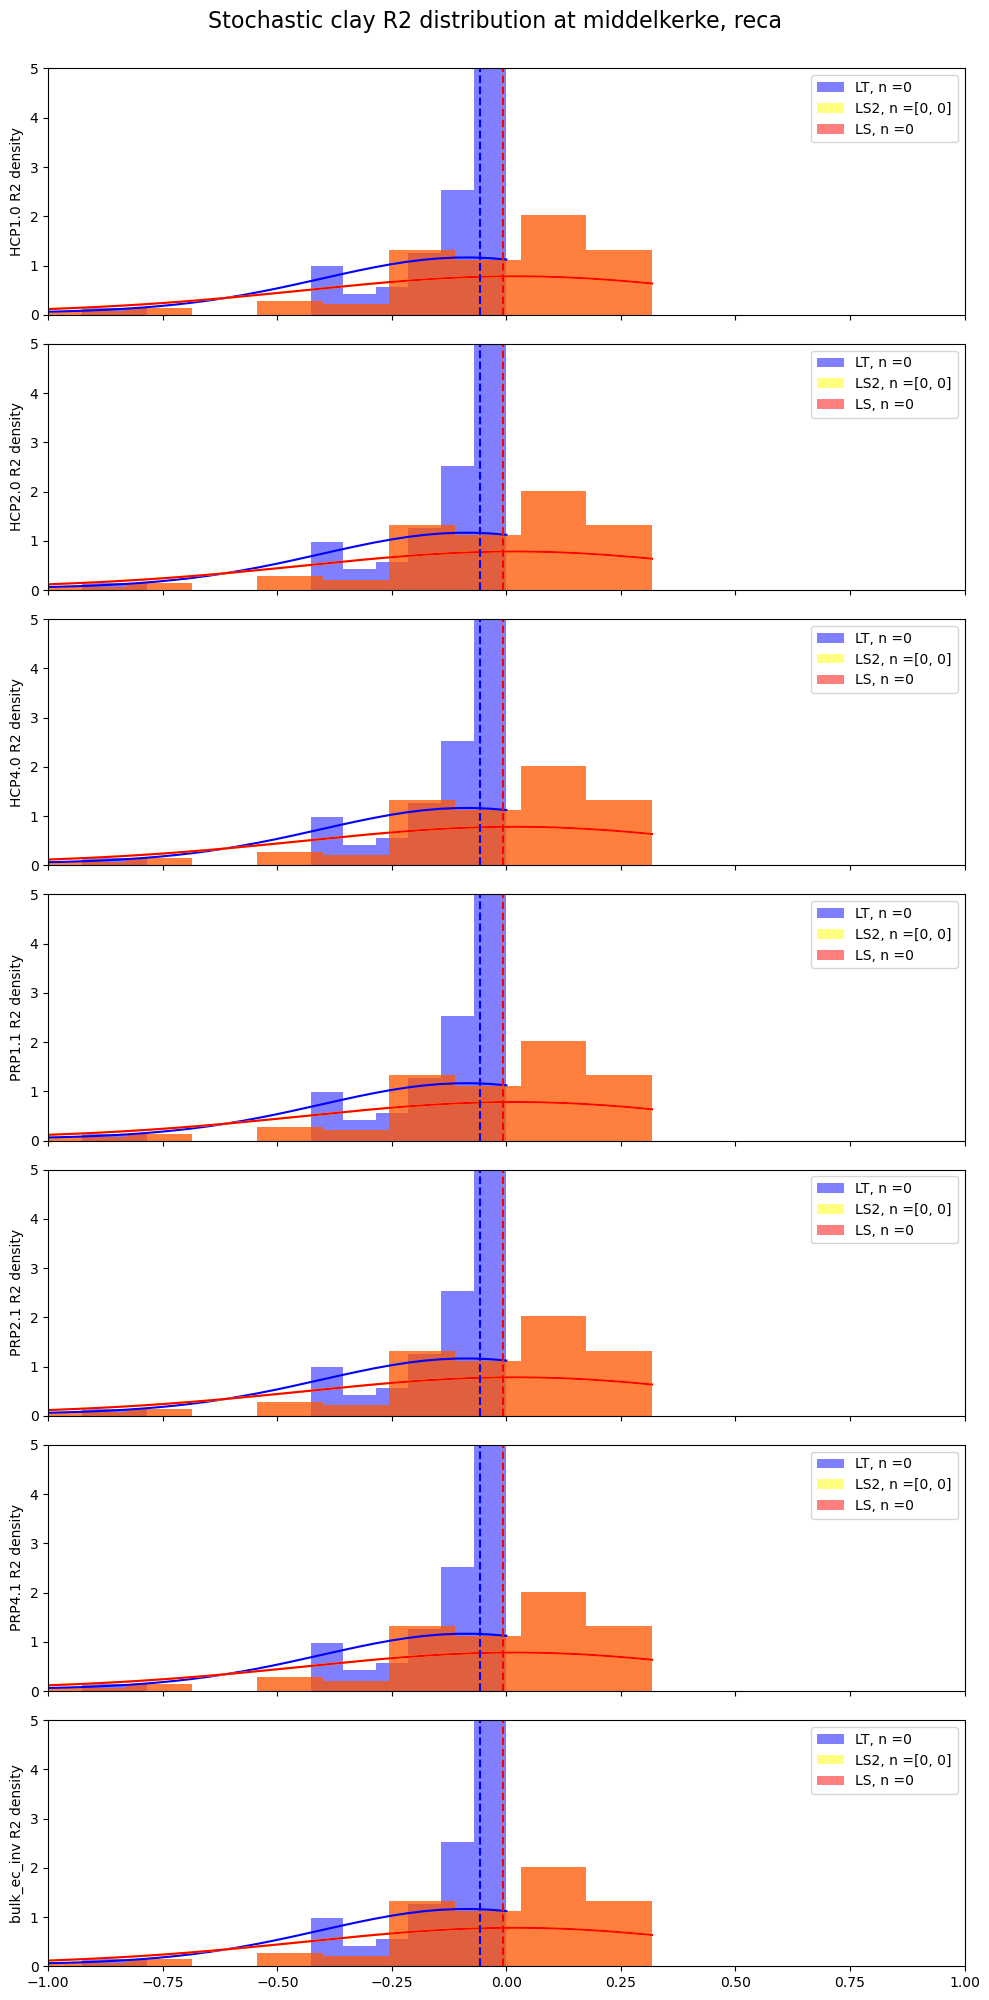

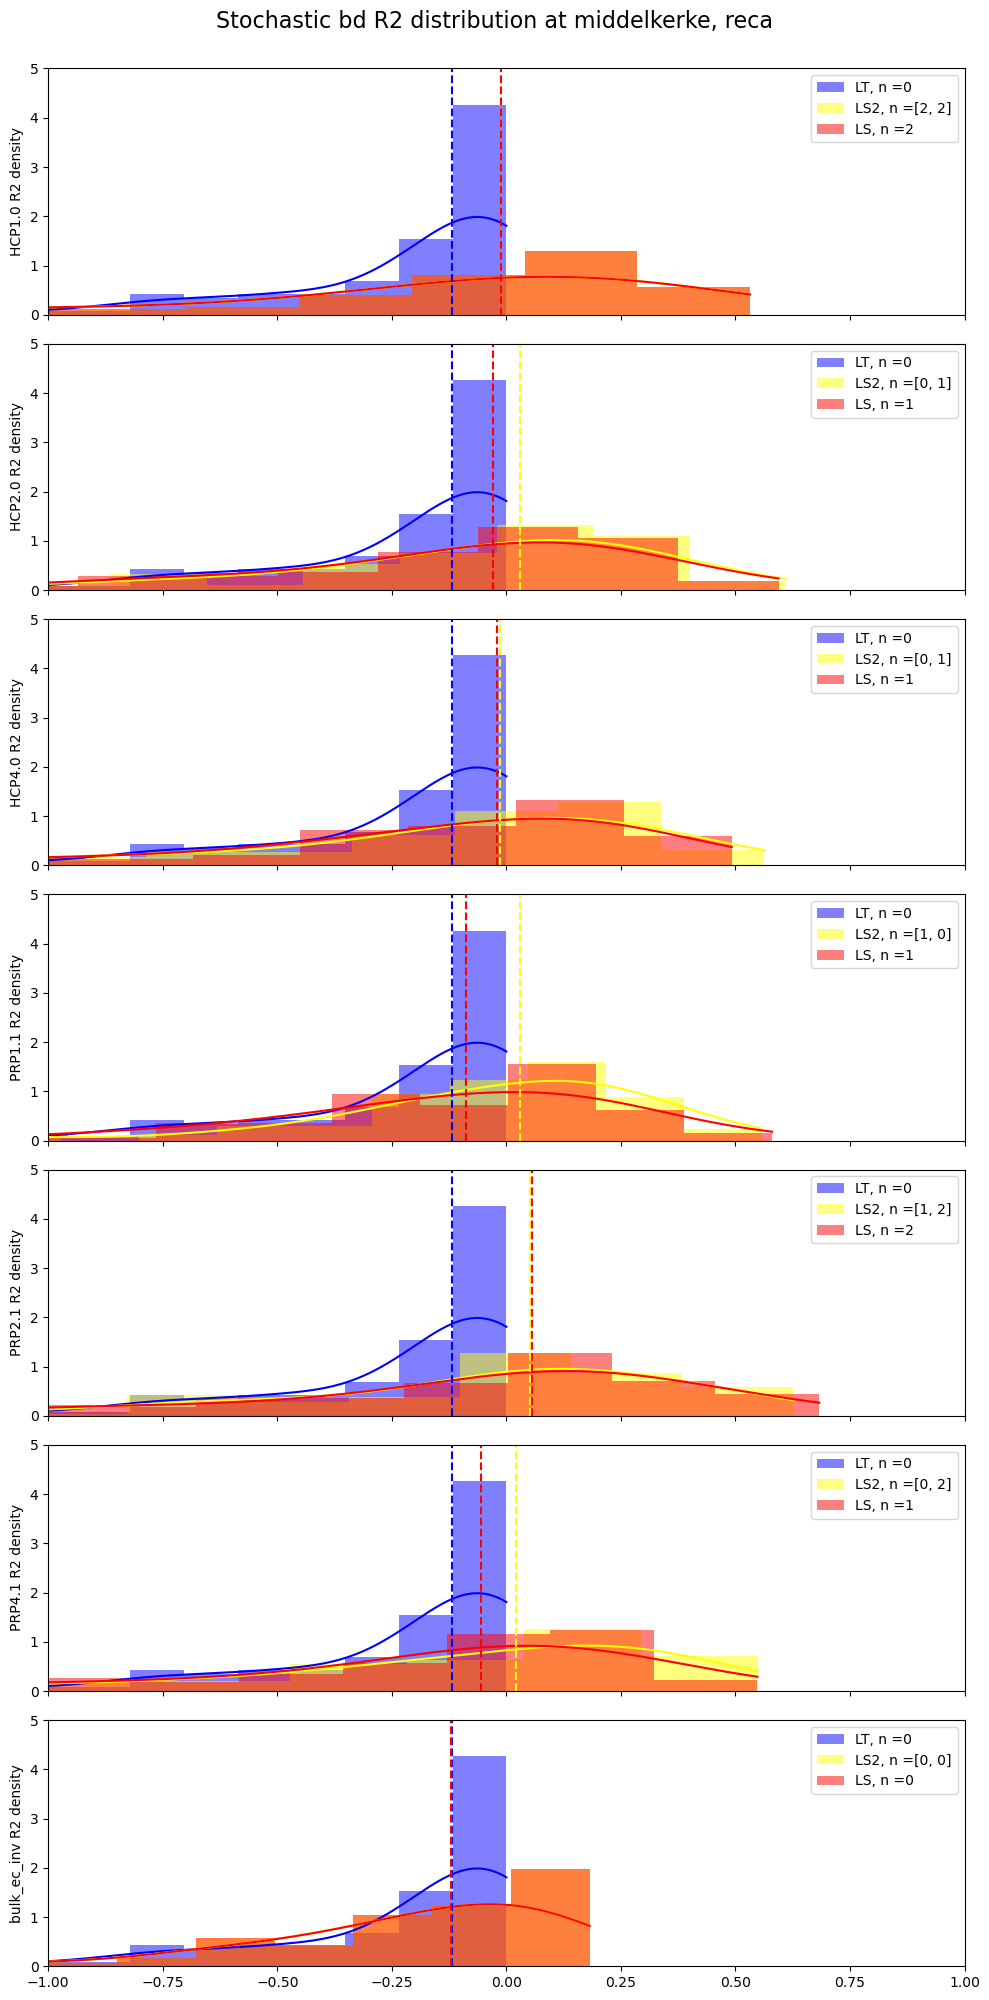

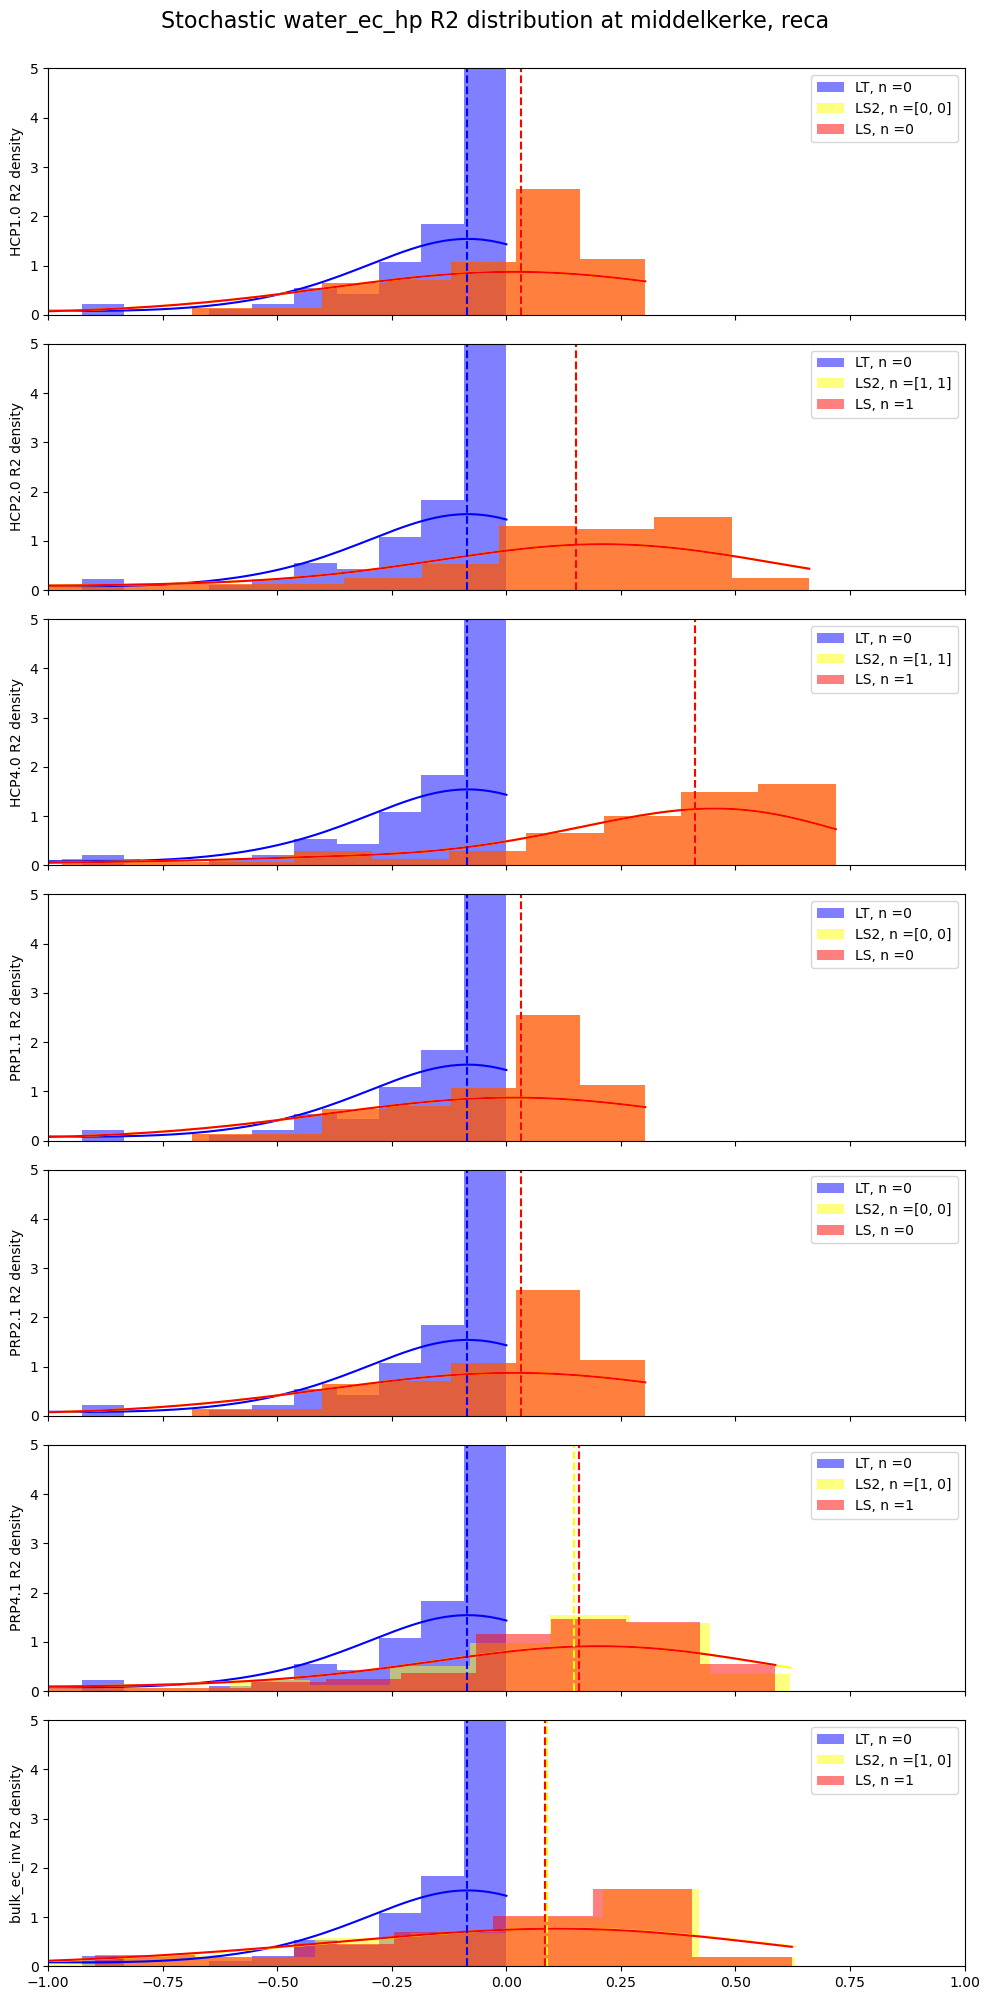

In [13]:
###########################
#### Store results ########
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]

Sresults = {}
SR2_results = pd.DataFrame(columns=['Target', 'Best Feature LT', 'R2 LT', 'Best Feature LS', 'R2 LS', 'Best Feature LS2', 'R2 LS2'
                               , 'Best Feature 10', 'R2 10', 'Best Feature 50', 'R2 50'])

pdfs = []
for i, target in enumerate(target_set):
    max_r2_lt = -float('inf')
    max_r2_ls = -float('inf')
    max_r2_ls2 = -float('inf')
    max_r2_10 = -float('inf')
    max_r2_50 = -float('inf')
    best_feature_lt = None
    best_feature_ls = None
    best_feature_ls2 = None

    for feature in feature_set:
        SR2_test_LT, SR2_test_LS, SR2_test_LS2, SR2_test_10, SR2_test_50, best_ns = stochastic(feature, target, ds_c)

        Sresults[feature] = {
            'LT': {'R2': SR2_test_LT, 'n': best_ns[0]},
            'LS': {'R2': SR2_test_LS, 'n': best_ns[1]},
            'LS2': {'R2': SR2_test_LS2, 'n': best_ns[2]},
            '10': {'R2': SR2_test_10, 'n': best_ns[2]},
            '50': {'R2': SR2_test_50, 'n': best_ns[2]}
        }

    for feature, result in Sresults.items():
        if np.median(result['LT']['R2']) > max_r2_lt:
            max_r2_lt = np.median(result['LT']['R2'])
            best_feature_lt = feature

        if np.median(result['LS']['R2']) > max_r2_ls:
            max_r2_ls = np.median(result['LS']['R2'])
            best_feature_ls = feature

        if np.median(result['LS2']['R2']) > max_r2_ls2:
            max_r2_ls2 = np.median(result['LS2']['R2'])
            best_feature_ls2 = feature

        if np.median(result['10']['R2']) > max_r2_10:
            max_r2_10 = np.median(result['10']['R2'])
            best_feature_10 = feature

        if np.median(result['50']['R2']) > max_r2_50:
            max_r2_50 = np.median(result['50']['R2'])
            best_feature_50 = feature

    SR2_results.loc[i, 'Target'] = target
    SR2_results.loc[i, 'Best Feature LT'] = best_feature_lt
    SR2_results.loc[i, 'R2 LT'] = max_r2_lt
    SR2_results.loc[i, 'Best Feature LS'] = best_feature_ls
    SR2_results.loc[i, 'R2 LS'] = max_r2_ls
    SR2_results.loc[i, 'Best Feature LS2'] = best_feature_ls2
    SR2_results.loc[i, 'R2 LS2'] = max_r2_ls2
    SR2_results.loc[i, 'Best Feature 10'] = best_feature_10
    SR2_results.loc[i, 'R2 10'] = max_r2_10
    SR2_results.loc[i, 'Best Feature 50'] = best_feature_50
    SR2_results.loc[i, 'R2 50'] = max_r2_50

    file_name = plot_stoch(Sresults, feature_set, target, profile_prefix, em_intype, cal, s_site, 'R2', 'blue', 'red', 'yellow')
    pdfs.append(file_name)

In [14]:
folder_path = 'output_images/'

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdfs:
    merger.append(folder_path + pdf)
merged_pdf_filename = f"R2_stoch_{s_site}_{cal}_{em_intype}.pdf"
outfile_transect_pdf = os.path.join(folder_path, merged_pdf_filename)
merger.write(outfile_transect_pdf)
merger.close()
for pdf in pdfs:
    os.remove(folder_path + pdf)
clear_output(wait=False)

In [15]:
folder_path = 'output_tables/'
file_name = 'SR2_results'+'_'+s_site+'_'+em_intype+'_'+cal+'_'+instrument_code+'.xlsx'
SR2_results.to_excel(folder_path + file_name, index=False)

SR2_results

,Target,Best Feature LT,R2 LT,Best Feature LS,R2 LS,Best Feature LS2,R2 LS2,Best Feature 10,R2 10,Best Feature 50,R2 50
0,vwc,HCP1.0,-0.1905,bulk_ec_inv,0.151,bulk_ec_inv,0.217,bulk_ec_inv,0.3955,HCP4.0,0.015
1,CEC,HCP1.0,-0.1085,HCP4.0,0.1355,HCP4.0,0.1355,HCP4.0,0.0365,HCP4.0,-0.1375
2,clay,HCP1.0,-0.058,HCP1.0,-0.0065,HCP1.0,-0.0065,HCP1.0,-0.315,HCP1.0,-0.1785
3,bd,HCP1.0,-0.119,PRP2.1,0.0565,PRP2.1,0.0515,PRP1.1,0.3335,PRP2.1,-0.043
4,water_ec_hp,HCP1.0,-0.087,HCP4.0,0.4115,HCP4.0,0.4115,HCP4.0,0.272,HCP4.0,-0.146


In [31]:
def plot_stoch_implementation_(df, Y, Ypred, r2, profile_prefix):
    fig, axes = plt.subplots(figsize=[7, 7])
    ss = 200

    label_for_depth_50_added = False
    label_for_depth_10_added = False

    axes.set_xlim(0, 60)
    axes.set_ylim(0, 60)

    # Plot a line and label for R2
    axes.plot([0, 60], [0, 60], color='black', label=f'R2 = {r2}')
    
    axes.set_ylabel(f'Water [%] predicted', fontsize=20)
    axes.set_xlabel(f'Water [%] observed in field', fontsize=20)

    for i, (x, y) in enumerate(zip(Y, Ypred)):
        if df['depth'].iloc[i] == 50:
            marker_style = 'D'
            c = 'orange'
            if not label_for_depth_50_added:
                axes.scatter(x*100, y*100, s=ss, alpha=0.8, color=c, marker=marker_style, label='Layer 50 cm')
                label_for_depth_50_added = True
            else:
                axes.scatter(x*100, y*100, s=ss, alpha=0.8, color=c, marker=marker_style)
        else:
            marker_style = 'o'
            c = 'blue'
            if not label_for_depth_10_added:
                axes.scatter(x*100, y*100, s=ss, alpha=0.8, color=c, marker=marker_style, label='Layer 10 cm')
                label_for_depth_10_added = True
            else:
                axes.scatter(x*100, y*100, s=ss, alpha=0.8, color=c, marker=marker_style)

    # Add the legend after all plotting is done
    axes.legend(fontsize=14)

    plt.suptitle(f'{profile_prefix}', fontsize=24)
    axes.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])

    axes.grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.99])

    # Save the figure with a filename that includes profile_prefix
    file_name_pdf = f"Stoch_VWC_{profile_prefix}.pdf"
    file_name_png = f"Stoch_VWC_{profile_prefix}.png"

    folder_path = 'output_images/'
    plt.savefig(folder_path + file_name_pdf)
    plt.savefig(folder_path + file_name_png)

    # Show the plot
    plt.show()

    return file_name

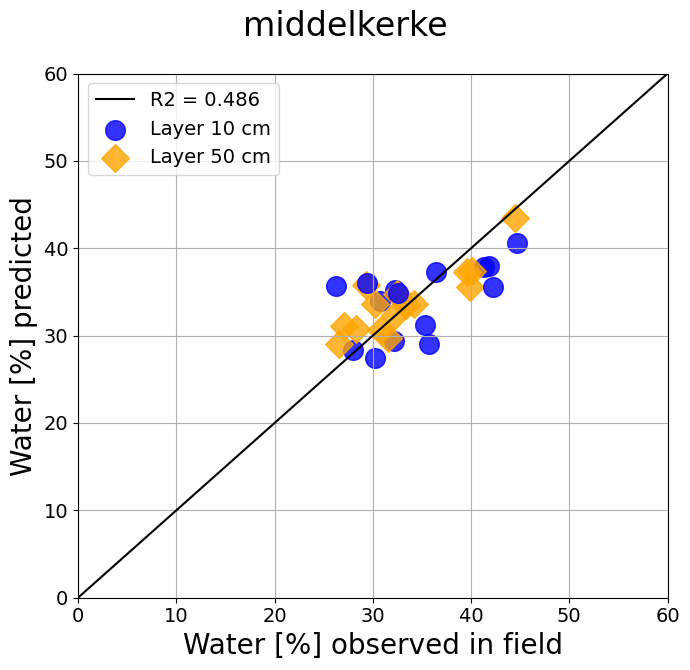

'SR2_results_M_reca_calibrated_421S.xlsx'

In [32]:
round_n = 3
target = 'vwc'

feature_10 = SR2_results[SR2_results['Target'] == 'vwc']['Best Feature 10'].iloc[0]
feature_50 = SR2_results[SR2_results['Target'] == 'vwc']['Best Feature 50'].iloc[0]

n_10 = Sresults[feature_10]['LS2']['n'][0]
n_50 = Sresults[feature_50]['LS2']['n'][1]

### Extract indices for 10 cm and 50 cm layers
idx_10 = ds_c[ds_c['depth'] == 10].index
idx_50 = ds_c[ds_c['depth'] == 50].index

### Select data at 10 cm depth
X_10 = ds_c.loc[idx_10, feature_10].values.reshape(-1, 1)
Y_10 = ds_c.loc[idx_10, target].values
### Select data at 50 cm depth
X_50 = ds_c.loc[idx_50, feature_50].values.reshape(-1, 1)
Y_50 = ds_c.loc[idx_50, target].values

#### Stochastic modelling for layers together
polySP_10 = PolynomialFeatures(degree=n_10)
polySP_10.fit(X_10)

Xt_10 = polySP_10.transform(X_10)
#Yt_10 = polySP_10.transform(Y_10)

LinRegSP = LinearRegression()
LinRegSP.fit(Xt_10, Y_10)
Ypred_10 = LinRegSP.predict(Xt_10)

#### Stochastic modelling for layers together
polySP_50 = PolynomialFeatures(degree=n_50)
polySP_50.fit(X_50)

Xt_50 = polySP_50.transform(X_50)

LinRegSP = LinearRegression()
LinRegSP.fit(Xt_50, Y_50)
Ypred_50 = LinRegSP.predict(Xt_50)

Y = np.concatenate((Y_10, Y_50))
Y_pred = np.concatenate((Ypred_10, Ypred_50))

r2 = round(r2_score(Y, Y_pred), round_n)

plot_stoch_implementation_(ds_c, Y, Y_pred, r2, profile_prefix)